This notebook is referenced from [Mitigating Noise on Real Quantum Computers — Programming on Quantum Computers Season 1 Ep 8
](https://www.youtube.com/watch?v=yuDxHJOKsVA&list=PLOFEBzvs-Vvp2xg9-POLJhQwtVktlYGbY&index=8)

In [8]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

qiskit.__qiskit_version__

{'qiskit-terra': '0.17.4', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.14.0', 'qiskit-aqua': '0.9.2', 'qiskit': '0.27.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [9]:
num_qubits = 3

# local simulator

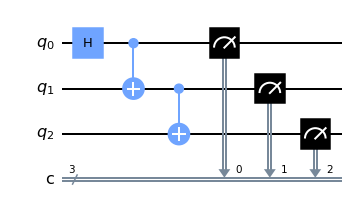

In [10]:
circuit = QuantumCircuit(num_qubits, num_qubits)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.measure([0, 1, 2], [0, 1, 2])

_ = circuit.draw()

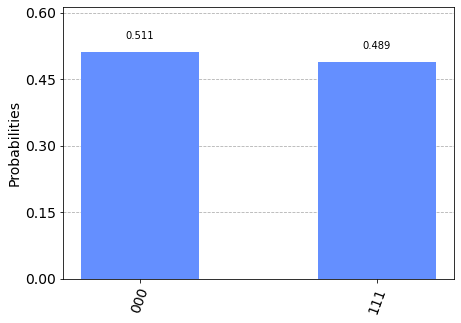

In [11]:
simulator = Aer.get_backend("qasm_simulator")
sim_result = execute(circuit, backend=simulator, shots=1024).result()
_ = plot_histogram(sim_result.get_counts(circuit))

# quamtum computer

In [12]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q")
device = provider.get_backend("ibmqx2")

In [13]:
job = execute(circuit, backend=device, shots=1024)
print(job.job_id())
job_monitor(job)

60ebff1c5ce0a2f70d591e90
Job Status: job has successfully run


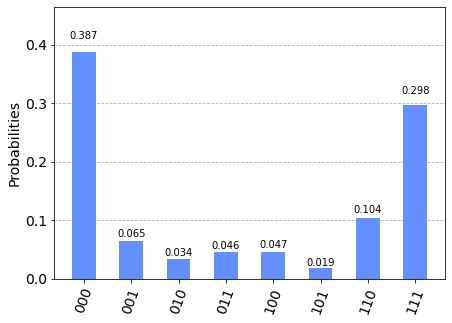

In [15]:
device_result = job.result()
_ = plot_histogram(device_result.get_counts(circuit))

# calibration

In [16]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [17]:
# Return a list of measurement calibration circuits for the full Hilbert space.
cal_circuits, state_labels = complete_meas_cal(qr=circuit.qregs[0], circlabel="measerrormitigationcal")

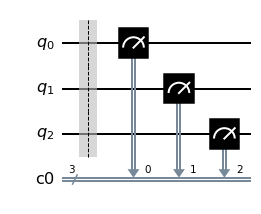

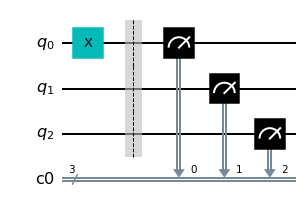

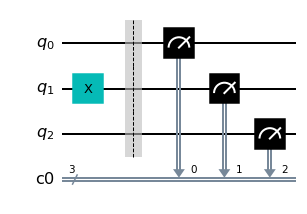

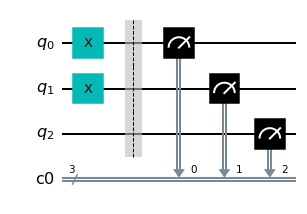

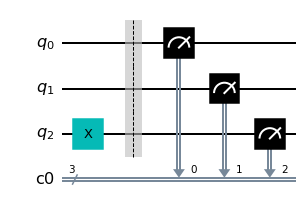

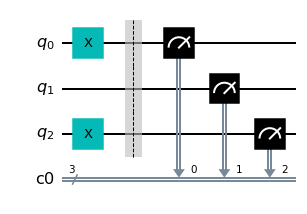

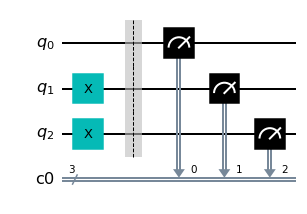

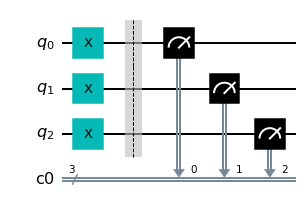

In [21]:
for c in cal_circuits:
    _ = c.draw()

In [22]:
print(len(cal_circuits))

8


In [23]:
cal_job = execute(
    cal_circuits,
    backend=device,
    shots=1024,
    optimization_level=0
)
print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()

60ec03abf54679414a520153
Job Status: job has successfully run


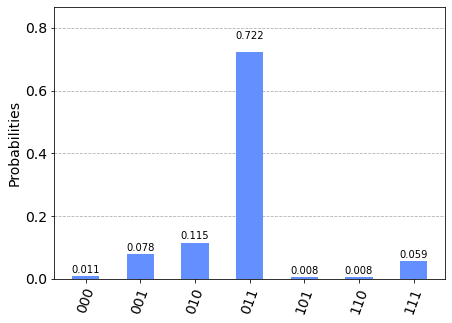

In [27]:
_ = plot_histogram(cal_results.get_counts(cal_circuits[3]))

In [28]:
# Initialize a measurement calibration matrix from the results of running 
# the circuits returned by `measurement_calibration_circuits`
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

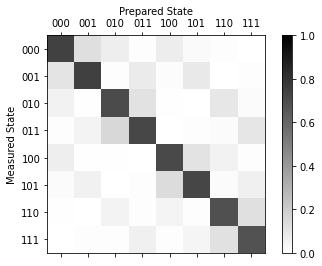

In [29]:
meas_fitter.plot_calibration()

In [30]:
meas_filter = meas_fitter.filter
mitigated_result = meas_filter.apply(device_result)

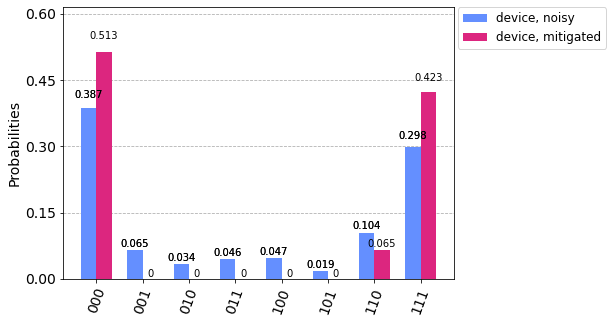

In [33]:
device_counts = device_result.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)
_ = plot_histogram(
    [device_counts, mitigated_counts],
    legend=["device, noisy", "device, mitigated"]
)

## apply to another circuit

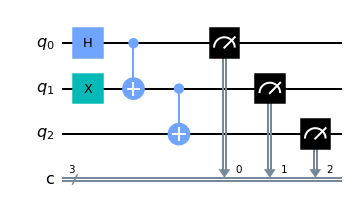

In [44]:
circuit2 = QuantumCircuit(3, 3)

circuit2.x(1)
circuit2.h(0)
circuit2.cx(0, 1)
circuit2.cx(1, 2)
circuit2.measure([0, 1, 2], [0, 1, 2])

_ = circuit2.draw()

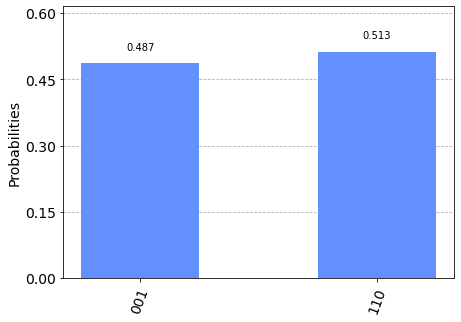

In [45]:
_ = plot_histogram(
    execute(circuit2, backend=simulator, shots=1024).result().get_counts(circuit2)
)

In [46]:
device_counts_2 = execute(circuit2, backend=device, shots=1024).result().get_counts(circuit2)

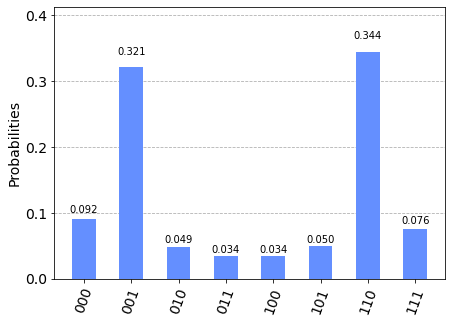

In [47]:
_ = plot_histogram(device_counts_2)

In [48]:
mitigated_counts_2 = meas_filter.apply(device_counts_2)

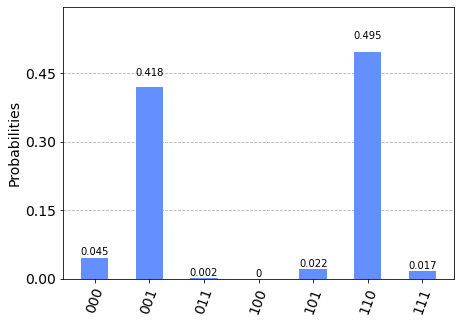

In [49]:
_ = plot_histogram(mitigated_counts_2)